Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.
The Data
Superstore sales data can be downloaded from https://community.tableau.com/docs/DOC-1236.

In [13]:
import warnings
import itertools 
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [15]:
df = pd.read_csv("/content/Sample - Superstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']

In [16]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

Data Preprocessing

In [17]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [18]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

Indexing with Time Series Data

In [19]:
furniture = furniture.set_index('Order Date')
furniture.index

Index(['1/1/2017', '1/10/2014', '1/10/2015', '1/10/2016', '1/11/2014',
       '1/11/2016', '1/12/2017', '1/13/2014', '1/13/2015', '1/13/2017',
       ...
       '9/7/2014', '9/7/2015', '9/7/2017', '9/8/2014', '9/8/2015', '9/8/2016',
       '9/8/2017', '9/9/2014', '9/9/2016', '9/9/2017'],
      dtype='object', name='Order Date', length=889)

Data Visualization

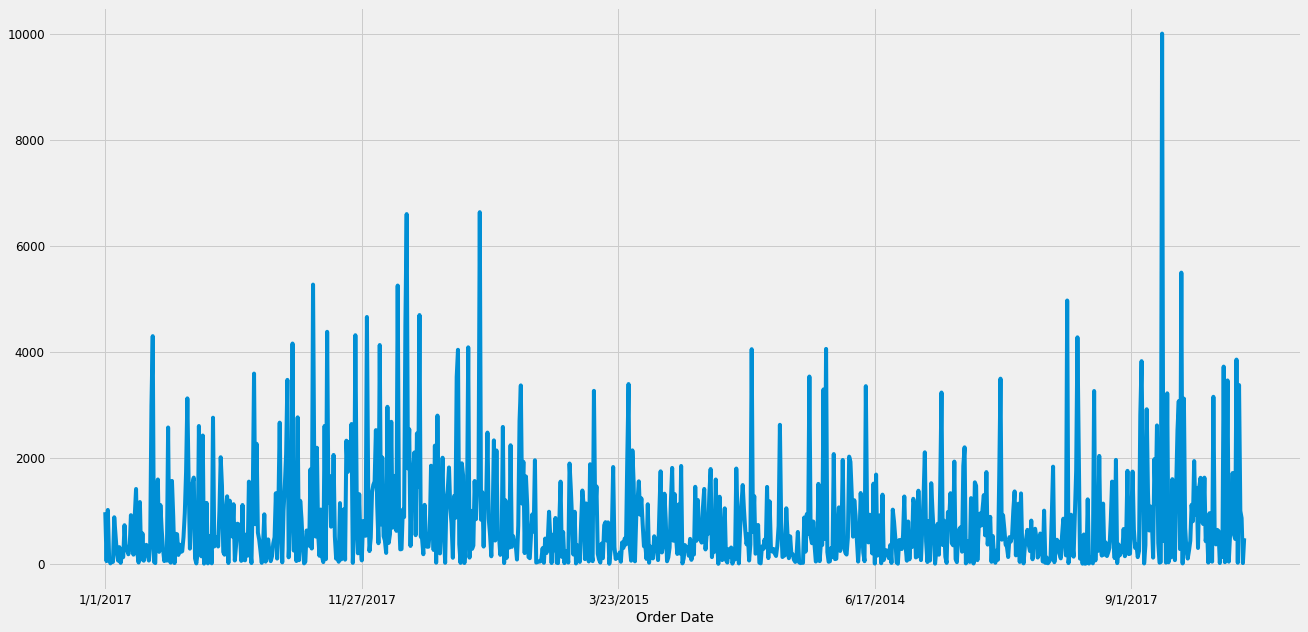

In [26]:
furniture['Sales'].plot(figsize=(20,10))
plt.show()

Time Series forecasting using ARIMA(Autoregressive Integrated Moving Average

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [35]:
mod = sm.tsa.statespace.SARIMAX(furniture,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0217      0.030     -0.718      0.473      -0.081       0.038
ma.L1         -1.0000      0.027    -37.329      0.000      -1.053      -0.948
ar.S.L12      -0.4719      0.017    -27.137      0.000      -0.506      -0.438
sigma2      1.449e+06   1.85e-08   7.84e+13      0.000    1.45e+06    1.45e+06


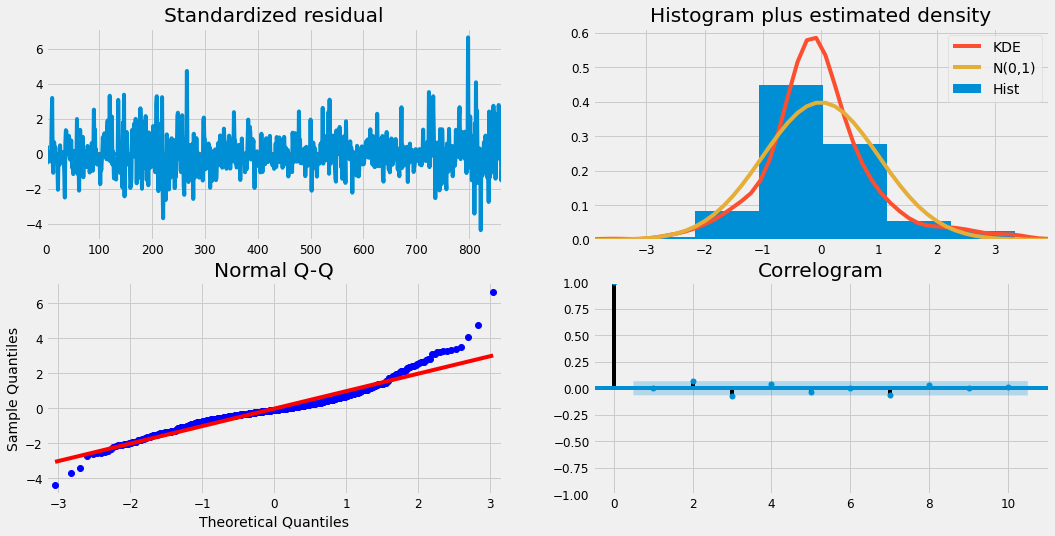

In [36]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

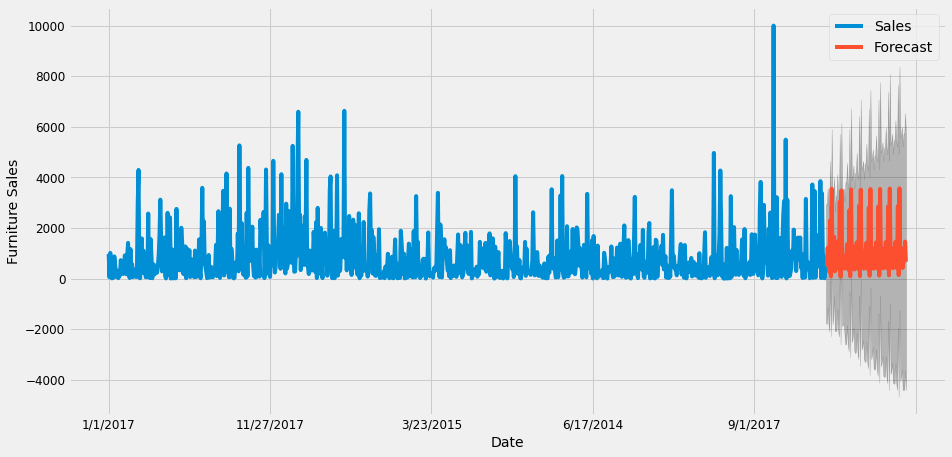

In [44]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = furniture.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()